### Scoring and Hyper-Parameter Tuning

Meta Labeling 응용에서 `scoring='f1'`으로 설정했다. 다른 응용에서는 표준 `scoring='accuracy'` 대신 `scoring='neg_log_loss'`로 설정했다. 비록 정확도가 더 직관적으로 해석되지만, 투자 전략의 Hyper Parameter Tuning에 있어서는 `neg_log_loss`를 사용하기를 권장한다. 그 이유는 다음과 같다.

Machine Learning 투자 전략이 높은 확률로 증권을 매수해야 한다는 예측을 했다고 가정해 보자. 전략에 대한 확신이 높으므로 대규모 long position을 취할 것이다. 만약 이 예측이 오류여서 시장이 하락한다면 많은 돈을 잃게 될 것이다. 하지만 정확도는 높은 확률로 잘못된 매수 예측을 한 경우와 낮은 확률로 잘못된 매수 예측을 한 경우를 동일하게 취급한다. 게다가 정확도는 높은 확률의 실수와 낮은 확률의 성공을 서로 상쇄시켜 버릴 수 있다. 

투자 전략은 높은 신뢰도로 올바른 label을 예측해야 수익을 얻을 수 있다. 낮은 신뢰도의 좋은 예측으로부터 획득하는 수익은 높은 신뢰도의 잘못된 예측으로부터 입는 손실을 만회하기에 충분하지 못하다. 이런 이유로 정확도는 분류기 성과의 현실적 점수를 반영하지 못한다. 이와 반대로 그 손실은 True Label이 주어졌을 때 분류기의 log likelihood를 계산하는데, 이는 예측 확률을 고려한다. log loss를 다음과 같이 측정할 수 있다.

$$L\left[Y,P\right] = -\log \left[ \text{Prob}[Y|P]\right] = -N^{-1}\sum_{n=0}^{N-1} \sum_{k=0}^{K-1} y_{n,k} \log\left( p_{n,k}\right)$$

여기서
- $p_{n,k}$는 label $k$의 예측 $n$과 연관된 확률이다.
- $Y$는 $K$ 이진 지표 행렬의 하나로서 관측값 $n$이 $K$개의 가능한 label 중 하나인 $k$에 할당되면 $y_{n,k} = 1$이고 아니면 $0$이다.

분류기가 2개의 1을 예측했다고 가정해 보자. 여기서 실제의 True label은 1과 0이라고 가정하자. 첫 번째 예측은 맞았지만, 두 번째 예측은 빗나갔으므로 정확도는 50%가 된다. 아래의 그림은 이런 예측들이 $[0.5,0.9]$ 사이의 확률에서 이뤄질 때의 Cross Entropy loss 그래프를 보여 준다. 그림의 오른쪽을 보면 정확도는 50%이지만, log loss는 높은 확률을 가진 빗나간 예측 때문에 매우 크다.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss

p_success = np.linspace(0.5, 0.9, 41)
p_failure = np.linspace(0.5, 0.9, 41) 

log_loss_matrix = np.zeros((len(p_success), len(p_failure)))

for i, p_s in enumerate(p_success):
    for j, p_f in enumerate(p_failure):
        y_true = np.array([1, 0])
        y_pred = np.array([p_s, p_f]) 
        loss = log_loss(y_true, np.vstack([1-y_pred, y_pred]).T) 
        log_loss_matrix[i, j] = loss

In [19]:
log_loss_matrix = pd.DataFrame(
    log_loss_matrix, 
    index = np.round(p_success,2), 
    columns = np.round(p_failure,2)
)
log_loss_matrix.sort_index(ascending = False, inplace = True)

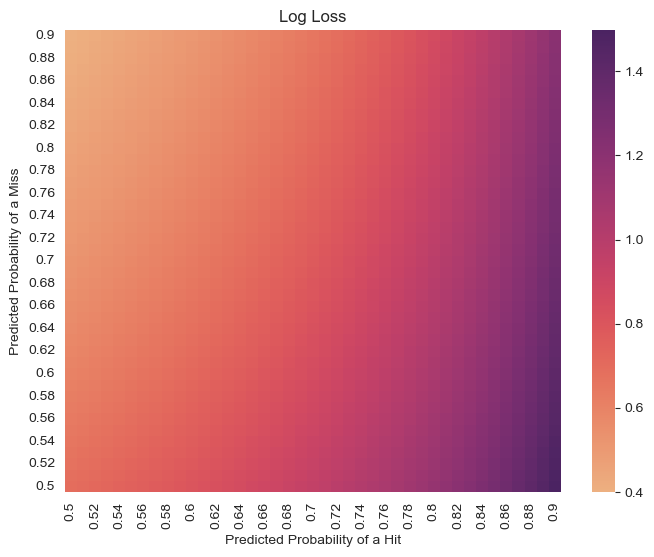

In [30]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(
    log_loss_matrix, 
    annot = False,
    cmap = 'flare',
    ax = ax
)

plt.xlabel("Predicted Probability of a Hit")
plt.ylabel("Predicted Probability of a Miss")
plt.title("Log Loss")
plt.show()

정확도보타 Cross Entropy loss를 선호하는 두 번째 이유가 있다. Cross Validation은 Sample Weights를 적용해 분류기의 점수를 구한다. Sample Weights는 관측의 절대 수익률의 함수로 결정됐다는 것을 기억할 것이다. 이는 Sample Weights Cross Validation Loss는 분류기의 성과를 추정하는데 시가 평가 이익과 손실과 관련된 변수 관점에서 추정함을 의미한다. 방향성에는 정확한 label을, position의 크기에는 확률을, 관측값의 수익률 혹은 결과에 대해서는 sampel weights를 사용한다. log loss는 금융 응용에 있어 Hyper Parameter Tuning을 위한 적절한 머신러닝 성과 척도가 되지만, 정확도는 그렇지 않다.

log loss를 성과 점수로 사용할 때 대개 부호를 바꾸는 것을 선호하는데, 이 때문에 `neg_log_loss`라고 불린다. 이렇게 바꾸는 이유는 직관적으로 보기 좋게 하기 위해서이다. 즉, 정확도에서와 마찬가지로 높은 negative log loss를 낮은 negative log loss보다 더 선호하도록 하기 위함이다. 